# Load data

In [1]:
import pandas as pd
import os

In [4]:
# Define the file path and file name pattern
file_path = '../../Data_folder/New_data_Fluo_C2DL_Huh7/New_Data/Test/Fluo-C2DL-Huh7/01_CSV/csv/'  # Update this to your actual file path
file_name_frame = 'frame_{:03d}.csv'

In [5]:
# Initialize an empty list to store DataFrames
data_frames = []

# Loop through the file names from frame_000.csv to frame_029.csv
for i in range(30):
    file_name = file_name_frame.format(i)
    full_path = os.path.join(file_path, file_name)
    
    # Read the CSV file and select the required columns
    df = pd.read_csv(full_path, usecols=['seg_label', 'centroid_row', 'centroid_col'])
    
    # Add a new column 'frame' to indicate the frame number
    df['frame'] = i
    
    # Append the DataFrame to the list
    data_frames.append(df)



In [37]:
# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(all_data.head(10))


   seg_label  centroid_row  centroid_col  frame
0          1           281           242      0
1          2           266           520      0
2          3           208           597      0
3          4           358           416      0
4          5           364           510      0
5          6           350           587      0
6          7           396           650      0
7          8           449           571      0
8          9           485           485      0
9         10           588           437      0


In [5]:
unique_counts = all_data.groupby('frame')['seg_label'].nunique()
print('number of cell in each frame',unique_counts)

number of cell in each frame frame
0     31
1     31
2     31
3     31
4     32
5     32
6     32
7     32
8     32
9     32
10    31
11    31
12    31
13    31
14    31
15    32
16    32
17    32
18    32
19    32
20    32
21    32
22    32
23    32
24    32
25    32
26    32
27    32
28    32
29    32
Name: seg_label, dtype: int64


In [6]:
print(unique_counts.unique())

[31 32]


## Problem: have some missing value in some frame

In [7]:
# Find the minimum and maximum values of seg_label
min_seg_label = all_data['seg_label'].min()
max_seg_label = all_data['seg_label'].max()

In [8]:
print(f"Min seg_label: {min_seg_label}, Max seg_label: {max_seg_label}")


Min seg_label: 1, Max seg_label: 37


check weather all value from 1 to 37 are used

In [9]:
# Create a DataFrame with all possible seg_label values from min to max
all_seg_labels = pd.DataFrame({'seg_label': range(min_seg_label, max_seg_label + 1)})
print(f"Original all_data shape: {all_data.shape}")
# Merge this DataFrame with all_data to ensure all seg_label values are present
all_data_2 = all_seg_labels.merge(all_data, on='seg_label', how='left')
print(f"Merged all_data_2 shape: {all_data_2.shape}")

Original all_data shape: (951, 4)
Merged all_data_2 shape: (954, 4)


-> there're some missing label from 1 to 37

In [10]:
all_data_filtered = all_data
# Count the number of times each seg_label appears across all frames
seg_label_counts = all_data_filtered['seg_label'].value_counts().sort_index()
# Create a DataFrame to ensure all seg_labels from 1 to 37 are included
all_seg_labels = pd.DataFrame({'seg_label': range(1, 38)})
# Merge with the counts to include seg_labels with zero counts
seg_label_counts = all_seg_labels.merge(seg_label_counts, left_on='seg_label', right_index=True, how='left').fillna(0)

# Rename the columns for clarity
seg_label_counts.columns = ['seg_label', 'count']

# Sort the DataFrame by seg_label in ascending order
seg_label_counts = seg_label_counts.sort_values(by='count', ascending=True)

# Display the result
print(seg_label_counts)

    seg_label  count
34         35    0.0
32         33    0.0
29         30    0.0
30         31    4.0
27         28   10.0
28         29   15.0
33         34   26.0
31         32   26.0
20         21   30.0
21         22   30.0
22         23   30.0
23         24   30.0
0           1   30.0
25         26   30.0
26         27   30.0
19         20   30.0
24         25   30.0
35         36   30.0
18         19   30.0
16         17   30.0
1           2   30.0
2           3   30.0
3           4   30.0
4           5   30.0
5           6   30.0
6           7   30.0
7           8   30.0
8           9   30.0
9          10   30.0
10         11   30.0
11         12   30.0
12         13   30.0
13         14   30.0
14         15   30.0
15         16   30.0
17         18   30.0
36         37   30.0


-> many seg lables are not used, many label count left than 30.

In [11]:
print(seg_label_counts['count'].sum())

951.0


In [12]:
print(all_data.shape[0])

951


# Handle missing data

* Using Forward Fill and Backward Fill with missing data
* Don't use extra label

In [13]:

print('number of used label: ',all_data['seg_label'].nunique())

number of used label:  34


In [14]:
print('number of missing data: ',34*30 - all_data.shape[0])

number of missing data:  69


*fill 69 missing data by Forward Fill and Backward Fill*

Our goal is to ensure all 34 unique segmentation labels (seg_labels) appear in every frame. To achieve this, we perform the following: <br>
* **For each frame 'i', if seg_label 'j' is missing from frame 'i':**
    * We add it using the centroid (centroid_row, centroid_col) of 'j' from a previous frame.
    * If 'j' hasn't appeared before 'i': We use the centroid coordinates from a frame after 'i'.<br>
* **This process ensures that all 34 seg_labels are present in every frame, even if they haven't been actively detected.**

In [15]:
# Identify all unique seg_label values
unique_seg_labels = all_data['seg_label'].unique()
unique_seg_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 36, 37, 32, 34, 29],
      dtype=int64)

In [16]:
# Create a DataFrame with all possible combinations of seg_label and frame
all_seg_labels = pd.DataFrame({'seg_label': unique_seg_labels})
all_frames = pd.DataFrame({'frame': all_data['frame'].unique()})
all_combinations = all_seg_labels.merge(all_frames, how='cross')

# Merge this DataFrame with all_data to ensure all seg_label values are present in each frame
filled_data = all_combinations.merge(all_data, on=['seg_label', 'frame'], how='left')

# Iterate through each frame and fill missing values
for frame in filled_data['frame'].unique():
    current_frame_data = filled_data[filled_data['frame'] == frame]
    for seg_label in unique_seg_labels:
        if current_frame_data[current_frame_data['seg_label'] == seg_label].isnull().values.any():
            # If seg_label is missing in the current frame, find the nearest previous or future frame
            previous_frames = filled_data[(filled_data['seg_label'] == seg_label) & (filled_data['frame'] < frame)].dropna()
            future_frames = filled_data[(filled_data['seg_label'] == seg_label) & (filled_data['frame'] > frame)].dropna()
            
            if not previous_frames.empty:
                # Use the value from the nearest previous frame
                nearest_previous_frame = previous_frames.iloc[-1]
                filled_data.loc[(filled_data['frame'] == frame) & (filled_data['seg_label'] == seg_label), ['centroid_row', 'centroid_col']] = nearest_previous_frame[['centroid_row', 'centroid_col']]
            elif not future_frames.empty:
                # Use the value from the nearest future frame
                nearest_future_frame = future_frames.iloc[0]
                filled_data.loc[(filled_data['frame'] == frame) & (filled_data['seg_label'] == seg_label), ['centroid_row', 'centroid_col']] = nearest_future_frame[['centroid_row', 'centroid_col']]

# Display the first few rows of the filled data
print(filled_data.head())

   seg_label  frame  centroid_row  centroid_col
0          1      0         281.0         242.0
1          1      1         277.0         242.0
2          1      2         277.0         242.0
3          1      3         272.0         245.0
4          1      4         272.0         245.0


In [17]:
# Sort the filled_data DataFrame by frame and seg_label
filled_data = filled_data.sort_values(by=['frame', 'seg_label'])

# Display the first few rows of the sorted data
print(filled_data.head())

     seg_label  frame  centroid_row  centroid_col
0            1      0         281.0         242.0
30           2      0         266.0         520.0
60           3      0         208.0         597.0
90           4      0         358.0         416.0
120          5      0         364.0         510.0


In [18]:
print('number of missing data: ',34*30 - all_data.shape[0])

number of missing data:  69


In [19]:
print('number of missing data: ',34*30 - filled_data.shape[0])

number of missing data:  0


# Visualizaion data

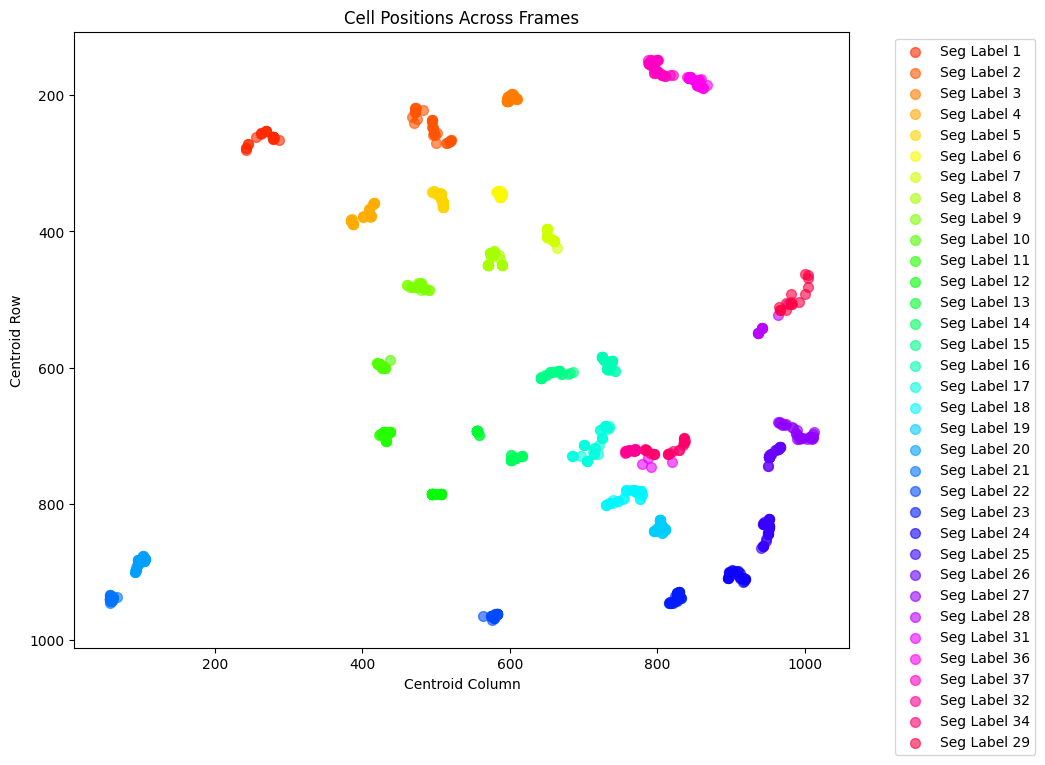

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a color palette with a unique color for each seg_label
palette = sns.color_palette("hsv", len(unique_seg_labels))
color_map = dict(zip(unique_seg_labels, palette))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through each frame and plot the centroids
for frame in filled_data['frame'].unique():
    frame_data = filled_data[filled_data['frame'] == frame]
    for seg_label in unique_seg_labels:
        seg_data = frame_data[frame_data['seg_label'] == seg_label]
        if not seg_data.empty:
            ax.scatter(seg_data['centroid_col'], seg_data['centroid_row'], 
                       color=color_map[seg_label], label=f'Seg Label {seg_label}' if frame == filled_data['frame'].min() else "", 
                       s=50, alpha=0.6)

# Add labels and title
ax.set_xlabel('Centroid Column')
ax.set_ylabel('Centroid Row')
ax.set_title('Cell Positions Across Frames')
ax.invert_yaxis()  # Invert y-axis to match image coordinates

# Create a legend with unique seg_labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

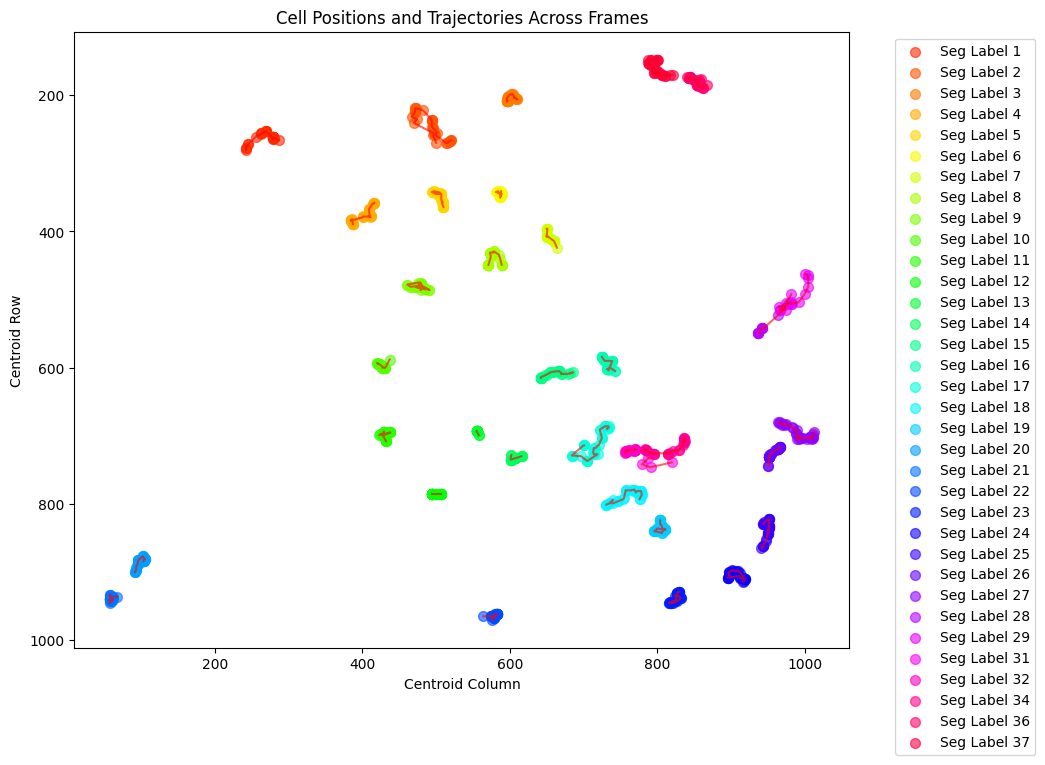

In [21]:

# Get unique seg_labels
unique_seg_labels = filled_data['seg_label'].unique()

# Create a color palette with a unique color for each seg_label
palette = sns.color_palette("hsv", len(unique_seg_labels))
color_map = dict(zip(unique_seg_labels, palette))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through each seg_label and plot the centroids and trajectories
for seg_label in unique_seg_labels:
    seg_data = filled_data[filled_data['seg_label'] == seg_label]
    if not seg_data.empty:
        # Plot the trajectory line
        ax.plot(seg_data['centroid_col'], seg_data['centroid_row'], color='red', alpha=0.6)
        # Plot the centroids
        ax.scatter(seg_data['centroid_col'], seg_data['centroid_row'], 
                   color=color_map[seg_label], label=f'Seg Label {seg_label}', 
                   s=50, alpha=0.6)

# Set labels and title
ax.set_xlabel('Centroid Column')
ax.set_ylabel('Centroid Row')
ax.set_title('Cell Positions and Trajectories Across Frames')
ax.invert_yaxis()  # Invert y-axis to match image coordinates

# Create a legend with unique seg_labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Clustering


In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure filled_data is sorted by frame and seg_label
filled_data = filled_data.sort_values(by=['frame', 'seg_label'])

print(filled_data.head())

     seg_label  frame  centroid_row  centroid_col
0            1      0         281.0         242.0
30           2      0         266.0         520.0
60           3      0         208.0         597.0
90           4      0         358.0         416.0
120          5      0         364.0         510.0


In [31]:

# Pivot the data to create a feature vector for each seg_label
pivot_data = filled_data.pivot(index='seg_label', columns='frame', values=['centroid_row', 'centroid_col'])

print(pivot_data.head())
print(pivot_data.shape)


          centroid_row                                                   \
frame               0      1      2      3      4      5      6      7    
seg_label                                                                 
1                281.0  277.0  277.0  272.0  272.0  261.0  257.0  256.0   
2                266.0  266.0  267.0  267.0  268.0  270.0  270.0  256.0   
3                208.0  208.0  208.0  208.0  208.0  208.0  208.0  208.0   
4                358.0  358.0  358.0  358.0  359.0  359.0  367.0  367.0   
5                364.0  364.0  364.0  364.0  364.0  364.0  364.0  358.0   

                         ... centroid_col                                     \
frame         8      9   ...           20     21     22     23     24     25   
seg_label                ...                                                   
1          256.0  253.0  ...        279.0  278.0  278.0  278.0  278.0  278.0   
2          256.0  241.0  ...        494.0  494.0  494.0  494.0  496.0  496.0   

In [33]:
# Flatten the multi-level columns
pivot_data.columns = [f'{col[0]}_{col[1]}' for col in pivot_data.columns]
print("\nFlattened pivot_data:")
print(pivot_data.head())
print(pivot_data.shape)



Flattened pivot_data:
           centroid_row_0  centroid_row_1  centroid_row_2  centroid_row_3  \
seg_label                                                                   
1                   281.0           277.0           277.0           272.0   
2                   266.0           266.0           267.0           267.0   
3                   208.0           208.0           208.0           208.0   
4                   358.0           358.0           358.0           358.0   
5                   364.0           364.0           364.0           364.0   

           centroid_row_4  centroid_row_5  centroid_row_6  centroid_row_7  \
seg_label                                                                   
1                   272.0           261.0           257.0           256.0   
2                   268.0           270.0           270.0           256.0   
3                   208.0           208.0           208.0           208.0   
4                   359.0           359.0           

In [32]:

# Drop rows with any missing values
pivot_data = pivot_data.dropna()

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pivot_data)

In [ ]:

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(normalized_data)


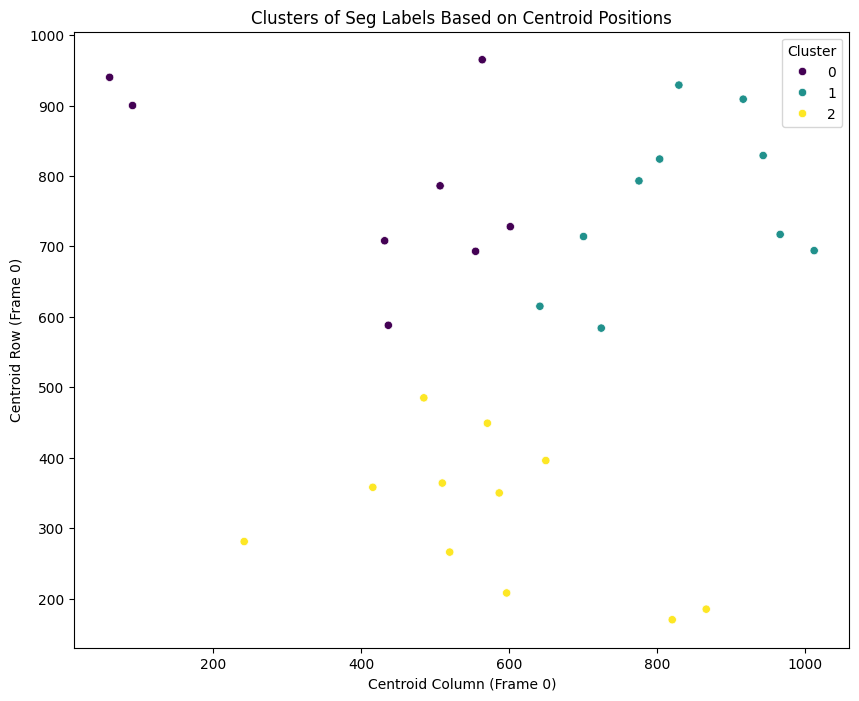

In [66]:

# Add the cluster labels to the original data
pivot_data['cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='centroid_col_0', y='centroid_row_0', hue='cluster', data=pivot_data, palette='viridis')
plt.xlabel('Centroid Column (Frame 0)')
plt.ylabel('Centroid Row (Frame 0)')
plt.title('Clusters of Seg Labels Based on Centroid Positions')
plt.legend(title='Cluster')
plt.show()

In [ ]:
E:\OneDrive\Máy tính\work_space\AI_learning\Git_Folder\Cell-Tracking\Data_folder\New_data_Fluo_C2DL_Huh7

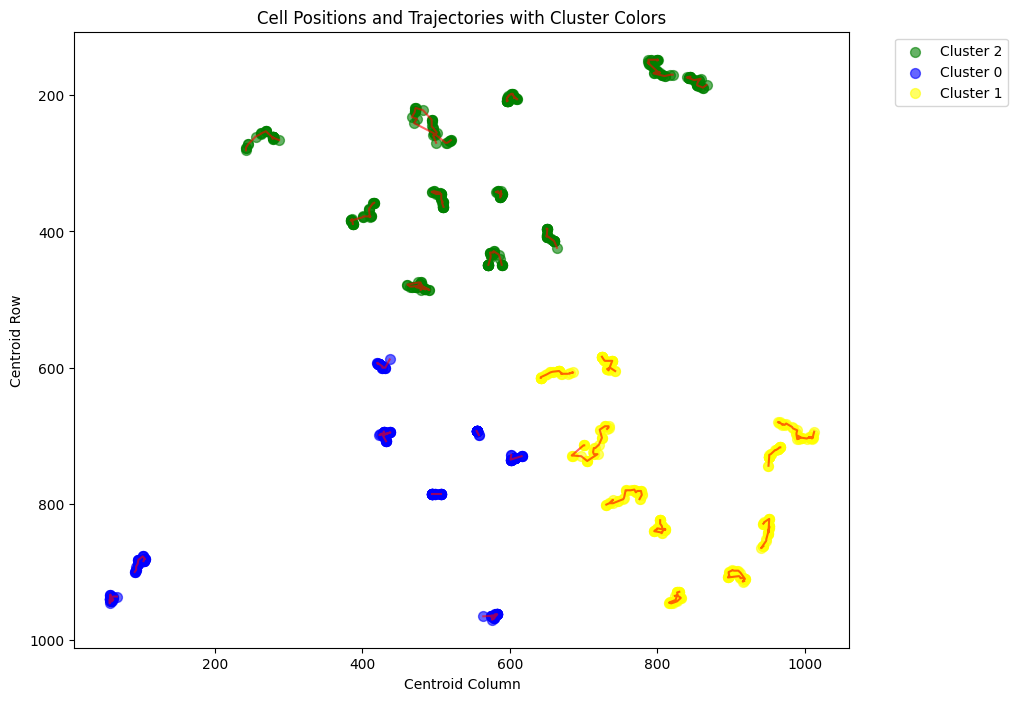

In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Add the cluster labels to the original data
filled_data['cluster'] = filled_data['seg_label'].map(dict(zip(pivot_data.index, clusters)))

# Filter out rows with NaN cluster labels
filled_data = filled_data.dropna(subset=['cluster'])

# Define cluster colors
cluster_colors = {0: 'blue', 1: 'yellow', 2: 'green'}

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the centroids and trajectories
for seg_label in filled_data['seg_label'].unique():
    seg_data = filled_data[filled_data['seg_label'] == seg_label]
    cluster = seg_data['cluster'].iloc[0]
    color = cluster_colors[cluster]
    
    if not seg_data.empty:
        # Plot the trajectory line
        ax.plot(seg_data['centroid_col'], seg_data['centroid_row'], color='red', alpha=0.6)
        # Plot the centroids
        ax.scatter(seg_data['centroid_col'], seg_data['centroid_row'], 
                   color=color, label=f'Cluster {cluster}', 
                   s=50, alpha=0.6)

# Set labels and title
ax.set_xlabel('Centroid Column')
ax.set_ylabel('Centroid Row')
ax.set_title('Cell Positions and Trajectories with Cluster Colors')
ax.invert_yaxis()  # Invert y-axis to match image coordinates

# Create a legend with cluster colors
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Using other k

## Plot function

In [69]:
# Function to plot clusters
def plot_clusters(k, filled_data, pivot_data, normalized_data):
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)

    # Add the cluster labels to the original data
    filled_data['cluster'] = filled_data['seg_label'].map(dict(zip(pivot_data.index, clusters)))

    # Filter out rows with NaN cluster labels
    filled_data = filled_data.dropna(subset=['cluster'])

    # Define cluster colors
    cluster_colors = {i: color for i, color in enumerate(['blue', 'red', 'green', 'purple', 'orange', 'brown'])}

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the centroids and trajectories
    for seg_label in filled_data['seg_label'].unique():
        seg_data = filled_data[filled_data['seg_label'] == seg_label]
        cluster = seg_data['cluster'].iloc[0]
        color = cluster_colors[cluster]

        if not seg_data.empty:
            # Plot the trajectory line
            ax.plot(seg_data['centroid_col'], seg_data['centroid_row'], color='red', alpha=0.6)
            # Plot the centroids
            ax.scatter(seg_data['centroid_col'], seg_data['centroid_row'], 
                       color=color, label=f'Cluster {cluster}', 
                       s=50, alpha=0.6)
    # Set labels and title
    ax.set_xlabel('Centroid Column')
    ax.set_ylabel('Centroid Row')
    ax.set_title(f'Cell Positions and Trajectories with Cluster Colors (k={k})')
    ax.invert_yaxis()  # Invert y-axis to match image coordinates

    # Create a legend with cluster colors
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

## Tranining using other k

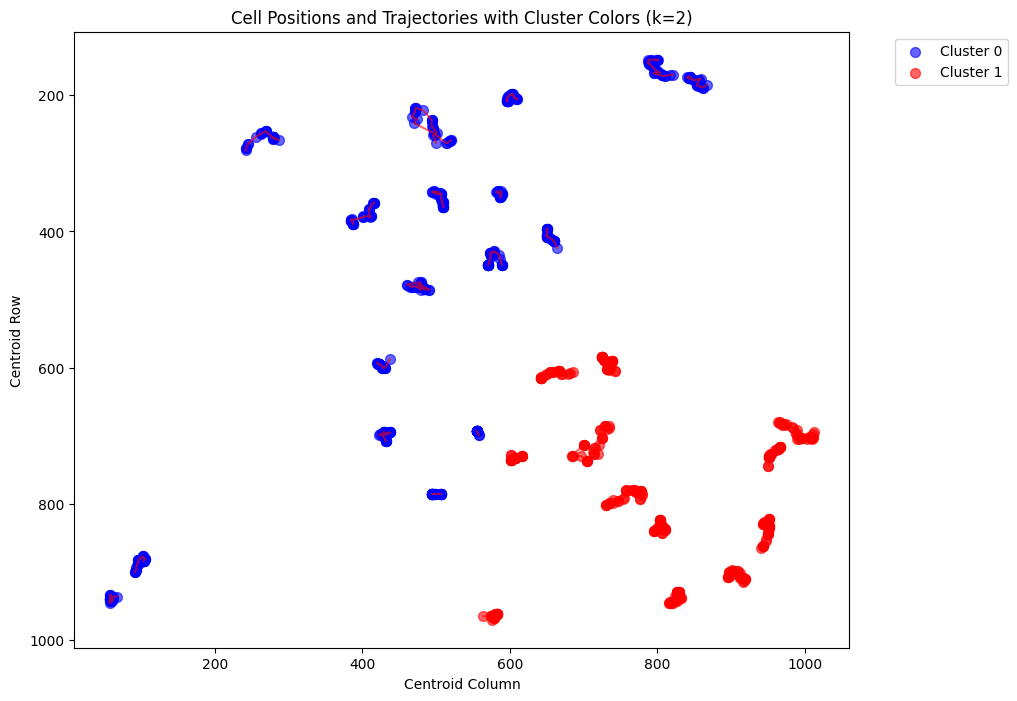

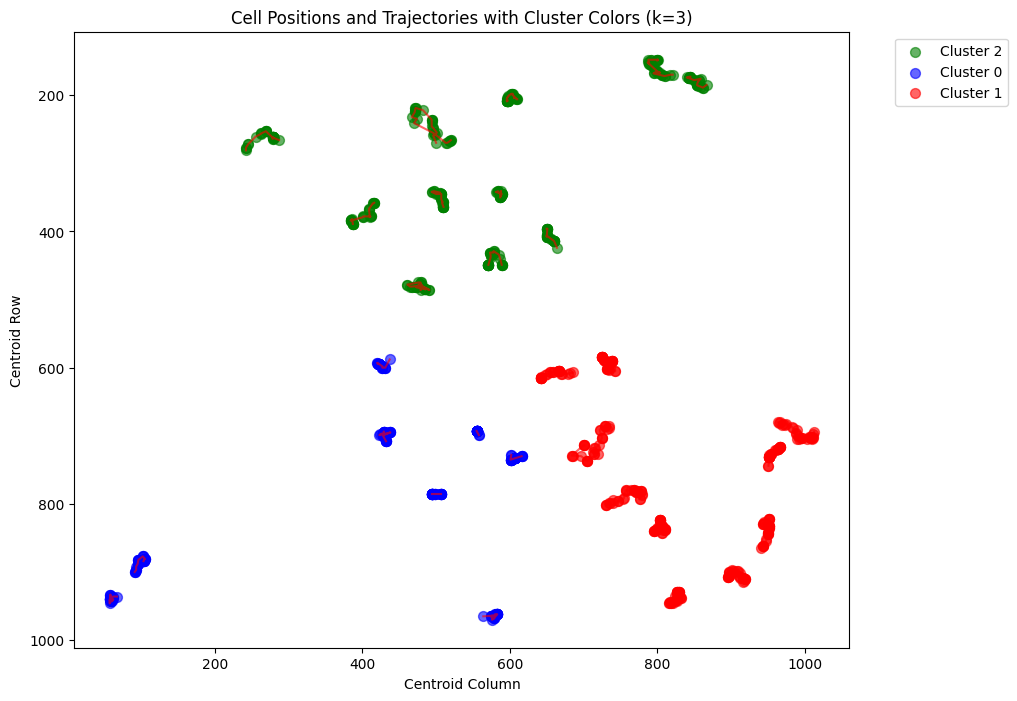

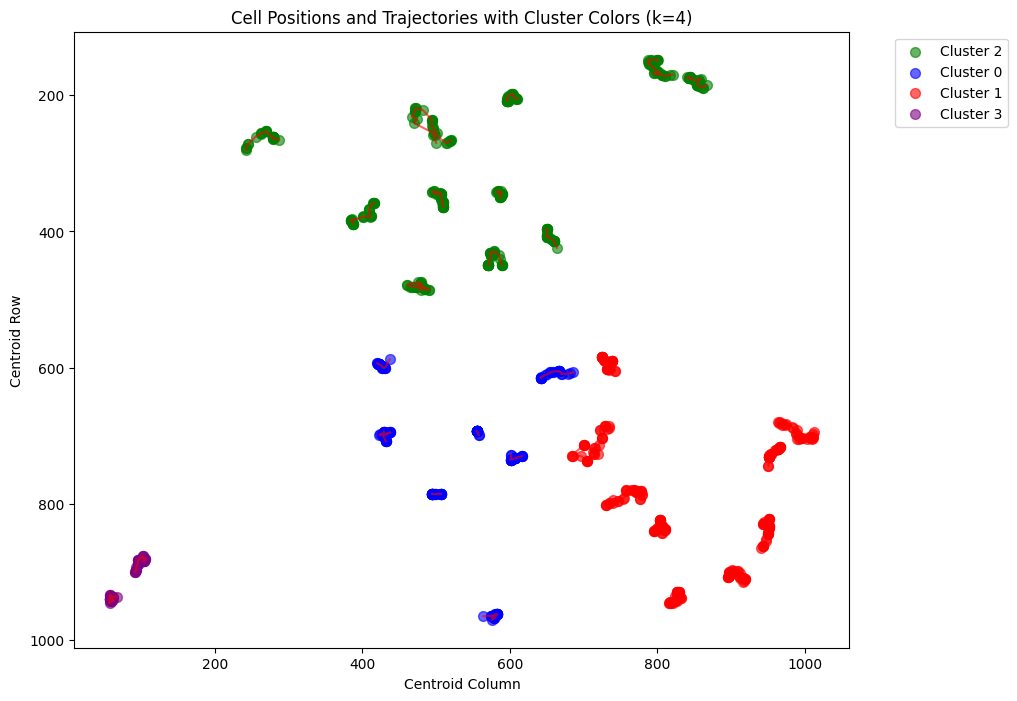

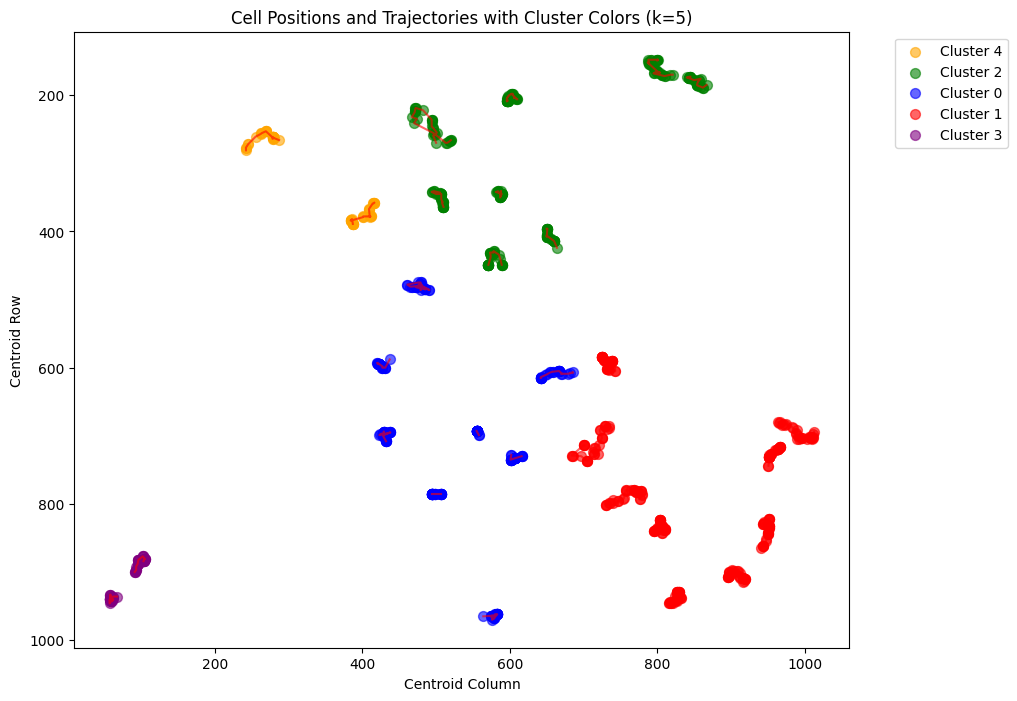

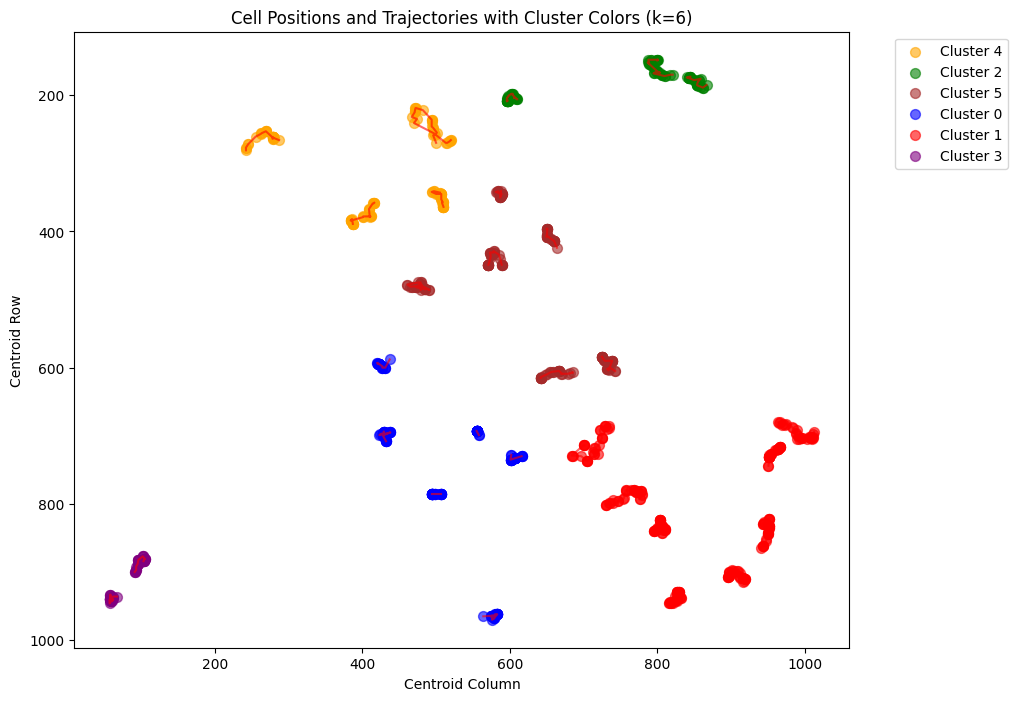

In [70]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure filled_data is sorted by frame and seg_label
filled_data = filled_data.sort_values(by=['frame', 'seg_label'])

# Pivot the data to create a feature vector for each seg_label
pivot_data = filled_data.pivot(index='seg_label', columns='frame', values=['centroid_row', 'centroid_col'])

# Flatten the multi-level columns
pivot_data.columns = [f'{col[0]}_{col[1]}' for col in pivot_data.columns]

# Drop rows with any missing values
pivot_data = pivot_data.dropna()

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pivot_data)

# Iterate over different values of k and plot the clusters
for k in range(2, 7):
    plot_clusters(k, filled_data.copy(), pivot_data, normalized_data)